In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn import neighbors
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spambase/spambase.DOCUMENTATION
/kaggle/input/spambase/spambase.data
/kaggle/input/spambase/spambase.names


# Load

In [2]:
columns = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'class']
spambase = pd.read_csv('/kaggle/input/spambase/spambase.data', names=columns)

In [3]:
X = spambase.drop('class', axis='columns')
y = spambase['class']

X_trains, X_tests = {}, {}

X_trains['raw'], X_tests['raw'], y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=25)

# Pre-process

In [4]:
# apply pre-processing on train and test sets separately
for X in [X_trains, X_tests]:
    df_log_all = X['raw'].copy()
    df_log_capital = X['raw'].copy()
    for c in df_log_all.columns:
        if c in ['capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']:
            df_log_capital[c] = np.log(df_log_capital[c] + 1)
        df_log_all[c] = np.log(df_log_all[c] + 1)
    X['log_all'] = df_log_all
    X['log_capital'] = df_log_capital
    X['minmax'] = MinMaxScaler().fit_transform(X['raw'].to_numpy())
    X['z'] = StandardScaler().fit_transform(X['raw'].to_numpy())

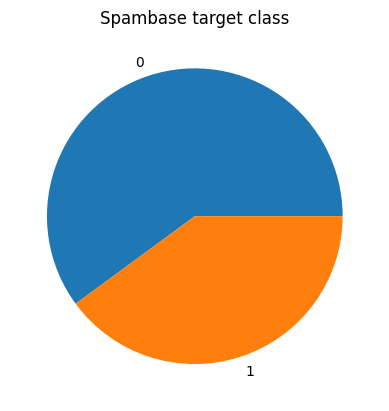

In [5]:
y_train.value_counts().plot(kind='pie', ylabel='')
plt.title("Spambase target class")
plt.savefig('spambase-y.png')

# Train

## Classifier 1 - k-nearest neighbours

In [6]:
gs_knn = {}
legend = []
for preprocess, X_train in X_trains.items():
    if preprocess == 'log_capital':
        continue
    X_test = X_tests[preprocess]
    print(f"KNN on {preprocess} set: ")
    # holdout
    knn = neighbors.KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_tests[preprocess])
    print(f"Original holdout training/test split - Accuracy: {knn.score(X_test,y_test)}, F-score: {f1_score(y_test, y_pred)}" )

    # Cross validation
    scores = model_selection.cross_val_score(knn, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
    
    scores = model_selection.cross_val_score(knn, X_train, y_train, scoring='f1')
    print("CV fold F1s:", scores)
    print("F1: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # grid search
    kvals=list(range(1,16))
    p = [1, 2]
    knng=model_selection.GridSearchCV(
        estimator=knn,
        param_grid = {'n_neighbors': kvals, 'p': p},
        scoring=['accuracy', 'f1'],
        refit='f1'
    )
    knng.fit(X_train,y_train)
    gs = pd.DataFrame.from_dict(knng.cv_results_)
    gs_knn[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (knng.best_score_,knng.best_estimator_.n_neighbors))
    knnresult=knng.predict(X_test)
    print("KNN ",knng.score(X_test,y_test))
    print(metrics.confusion_matrix(y_test,knnresult))

KNN on raw set: 
Original holdout training/test split - Accuracy: 0.8186753528773073, F-score: 0.7562043795620439
CV fold accuracies: [0.79755435 0.80706522 0.78532609 0.81929348 0.79619565]
Accuracies: 0.801 (+/- 0.011)
CV fold F1s: [0.75207987 0.7585034  0.72852234 0.77264957 0.74916388]
F1: 0.752 (+/- 0.014)
Grid search best score: 0.790, Best Estimator: 1.000000
KNN  0.7999999999999999
[[507  70]
 [ 68 276]]
KNN on log_all set: 
Original holdout training/test split - Accuracy: 0.9283387622149837, F-score: 0.9040697674418605
CV fold accuracies: [0.93478261 0.93206522 0.9048913  0.91440217 0.91847826]
Accuracies: 0.921 (+/- 0.011)
CV fold F1s: [0.91973244 0.91408935 0.87889273 0.89081456 0.89966555]
F1: 0.901 (+/- 0.015)
Grid search best score: 0.908, Best Estimator: 7.000000
KNN  0.9045521292217328
[[548  29]
 [ 36 308]]
KNN on minmax set: 
Original holdout training/test split - Accuracy: 0.8653637350705755, F-score: 0.8223495702005731
CV fold accuracies: [0.91440217 0.90625    0.89

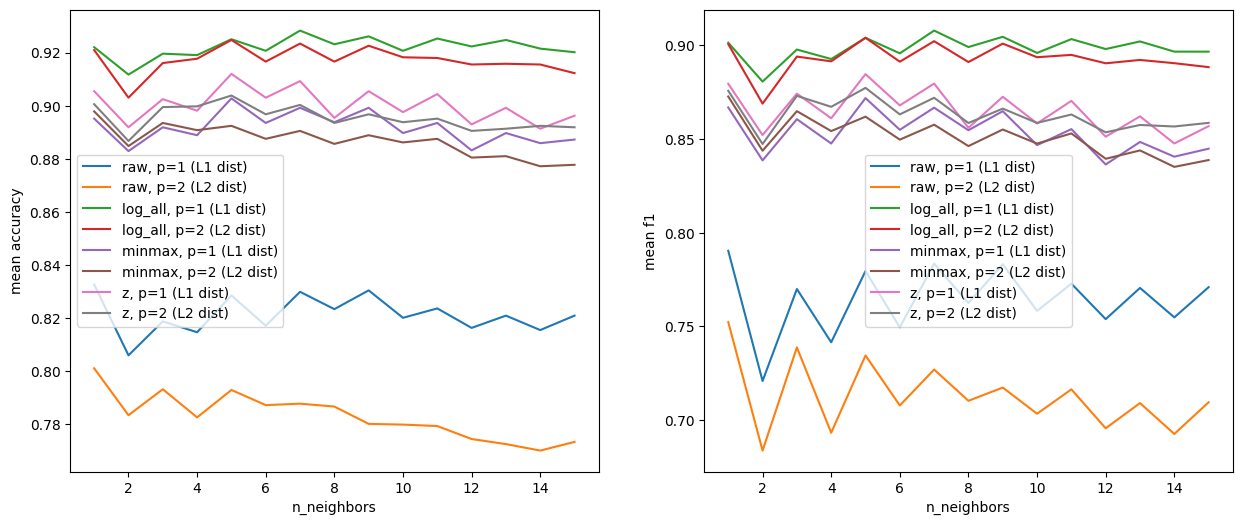

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
for i, score in enumerate(['accuracy', 'f1']):  
    legend = []
#     plt.subplot(int(f'12{i+1}'), figsize=(8, 4))
    for preprocess, results in gs_knn.items():    
        for p in [1, 2]:
            axs[i].plot(results[results['param_p'] == p]['param_n_neighbors'], results[results['param_p'] == p][f'mean_test_{score}'])
            legend.append(f'{preprocess}, p={p} (L{p} dist)')
    axs[i].set_xlabel('n_neighbors')
    axs[i].set_ylabel(f'mean {score}')
    axs[i].legend(legend)
plt.show()

## Classifier 2 - Decision tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

gs_dt = {}
legend = []
for preprocess, X_train in X_trains.items():
    if preprocess == 'log_capital':
        continue
    X_test = X_tests[preprocess]
    print(f"Decision Tree on {preprocess} set: ")
    # holdout
    dt = DecisionTreeClassifier(random_state=25)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_tests[preprocess])
    print(f"Original holdout training/test split - Accuracy: {dt.score(X_test, y_test)}, F-score: {f1_score(y_test, y_pred)}" )

    # Cross validation
    scores = model_selection.cross_val_score(dt, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
    
    scores = model_selection.cross_val_score(dt, X_train, y_train, scoring='f1')
    print("CV fold F1s:", scores)
    print("F1: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # grid search
    max_depths = [None] + list(range(1, 21))
    dtg = model_selection.GridSearchCV(
        estimator=dt,
        param_grid={'max_depth': max_depths},
        scoring=['accuracy', 'f1'],
        refit='f1'
    )
    dtg.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(dtg.cv_results_)
    gs_dt[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (dtg.best_score_, dtg.best_estimator_.max_depth))
    dtresult = dtg.predict(X_test)
    print("Decision Tree ", dtg.score(X_test, y_test))
    print(metrics.confusion_matrix(y_test, dtresult))


Decision Tree on raw set: 
Original holdout training/test split - Accuracy: 0.9305103148751357, F-score: 0.9080459770114941
CV fold accuracies: [0.91168478 0.89945652 0.91168478 0.90353261 0.91847826]
Accuracies: 0.909 (+/- 0.007)
CV fold F1s: [0.89184692 0.87328767 0.88964346 0.879046   0.89761092]
F1: 0.886 (+/- 0.009)
Grid search best score: 0.895, Best Estimator: 10.000000
Decision Tree  0.898379970544919
[[547  30]
 [ 39 305]]
Decision Tree on log_all set: 
Original holdout training/test split - Accuracy: 0.9261672095548317, F-score: 0.9020172910662825
CV fold accuracies: [0.91440217 0.90217391 0.91304348 0.90217391 0.91576087]
Accuracies: 0.910 (+/- 0.006)
CV fold F1s: [0.89517471 0.87713311 0.89115646 0.8779661  0.89491525]
F1: 0.887 (+/- 0.008)
Grid search best score: 0.896, Best Estimator: 10.000000
Decision Tree  0.8954344624447718
[[546  31]
 [ 40 304]]
Decision Tree on minmax set: 
Original holdout training/test split - Accuracy: 0.7980456026058632, F-score: 0.7603092783505

## Classifier 3 - Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Dictionary to store grid search results for different preprocessing methods
gs_lr = {}

# Loop over preprocessed data
for preprocess, X_train in X_trains.items():
    if preprocess == 'log_capital':
        continue
    
    X_test = X_tests[preprocess]
    
    print(f"Logistic Regression on {preprocess} set:")
    
    # Logistic Regression model
    lr = LogisticRegression(random_state=25, solver='newton-cg', max_iter=1000)
    
    # Holdout set evaluation
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f"Original holdout training/test split - Accuracy: {lr.score(X_test, y_test)}, F-score: {f1_score(y_test, y_pred)}")

    # Cross-validation
    scores = cross_val_score(lr, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    scores = cross_val_score(lr, X_train, y_train, scoring='f1')
    print("CV fold F1s:", scores)
    print("F1: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # Grid search for hyperparameter tuning
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lrg = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        scoring=['accuracy', 'f1'],
        refit='f1'
    )
    lrg.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(lrg.cv_results_)
    gs_lr[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (lrg.best_score_, lrg.best_estimator_.C))
    lrresult = lrg.predict(X_test)
    print("Logistic Regression ", lrg.score(X_test, y_test))
    print(confusion_matrix(y_test, lrresult))

Logistic Regression on raw set:
Original holdout training/test split - Accuracy: 0.9326818675352877, F-score: 0.9080118694362018
CV fold accuracies: [0.9388587  0.92255435 0.92119565 0.92798913 0.91168478]
Accuracies: 0.924 (+/- 0.009)
CV fold F1s: [0.92333901 0.90052356 0.89788732 0.90718039 0.88888889]
F1: 0.904 (+/- 0.011)
Grid search best score: 0.904, Best Estimator: 1.000000
Logistic Regression  0.9080118694362018
[[553  24]
 [ 38 306]]
Logistic Regression on log_all set:
Original holdout training/test split - Accuracy: 0.9424538545059717, F-score: 0.9228529839883551
CV fold accuracies: [0.94565217 0.93478261 0.93070652 0.94157609 0.92663043]
Accuracies: 0.936 (+/- 0.007)
CV fold F1s: [0.93127148 0.91666667 0.91099476 0.9254766  0.90753425]
F1: 0.918 (+/- 0.009)
Grid search best score: 0.920, Best Estimator: 10.000000
Logistic Regression  0.9199417758369723
[[550  27]
 [ 28 316]]
Logistic Regression on minmax set:
Original holdout training/test split - Accuracy: 0.903365906623235

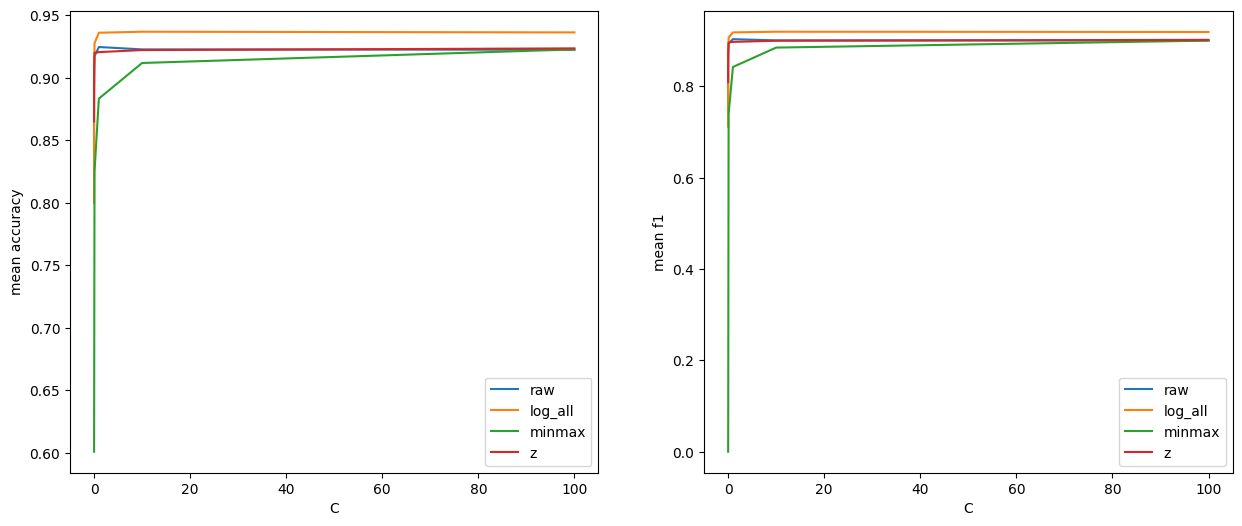

In [10]:
# Plotting results
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, score in enumerate(['accuracy', 'f1']):
    legend = []
    for preprocess, results in gs_lr.items():
        axs[i].plot(results['param_C'], results[f'mean_test_{score}'])
        legend.append(f'{preprocess}')
    axs[i].set_xlabel('C')
    axs[i].set_ylabel(f'mean {score}')
    axs[i].legend(legend)
plt.show()